The final array is of dimension Subjects x Instance (Rows) x Attributes (Columns).

* splitCsvF - Free Exploration
    * csvIntF would contain (user,category,correct)
* splitCsvFTI - Free Exploration with Training for those that are Informed (Exploration Phase)
    * informed contains (user,category,correct) for informed users (free exploration)
* splitCsvFTU - Free Exploration with Training for those that are Uninformed (Exploration Phase)
    * uninformed contains (user,category,correct) for informed users (free exploration)
* splitCsvSI - Strategic for those that are Informed (Exploration Phase)
    * informedSE contains (user,category,correct) for informed users (free exploration)
* splitCsvSU - Strategic for those that are Uninformed (Exploration Phase)
    * uninformedSE contains (user,category,correct) for uninformed users (free exploration)

And for training phase

* splitCsvFTTI - Free Exploration with Training for those that are Informed
    * informedFTT contains (user,category,correct) for informed users (training)
* splitCsvFTTU - Free Exploration with Training for those that are Uninformed
    * uninformedFTT contains (user,category,correct) for uninformed users (training)
* splitCsvSTI - Strategic for those that are Informed
    * informedST contains (user,category,correct) for informed users (training)
* splitCsvSTU - Strategic for those that are Uninformed
    * uninformedST contains (user,category,correct) for uninformed users (training)

# Open Loop

[A1 -First Selection by Task Category](#A1)

[A3 - Order of presentation during training](#A3)

[A9 - Performance during training wrt PC](#A9)

[A10 - Relative Performance during training](#A10)

[A11 - Learnability after training distribution (by groups)](#A11)

[A12 - Relative Learnability after training distribution (by groups)](#A12)

[A13 - Learnability after training distribution (by complexity)](#A13)

[A14 - Group Analysis (Linear Fit)](#A14)


####  Goal: we want to answer the following questions quantitatively. How is the first selection influenced by

*	(1) training performance A9,A10
*	(2) estimate of learnability after training A11,A12
*	(3) task instructions (group type)
*	(4) the knowledge that one of the tasks is unlearnable (informed vs uninformed comparison)

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import pylab
import pandas as pd
import warnings


from ipywidgets import widgets
from IPython.html.widgets import *
from __future__ import division

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=2)


import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

In [10]:
def stringToInt(arr, position, values):
    for i, v in enumerate(values):
        arr[arr[:,position] == v, position] = i
    return arr
np.set_printoptions(precision=4)

In [11]:
execute_notebook("Preprocessing.ipynb")

['free']
99
['free', 'train']
['free', 'test', 'train']


In [12]:
tasks = 4
catLab = ['1D', 'I1D', '2D', 'R']

usersF = np.shape(np.unique(csvIntF[:,0]))[0]
# For free exploration with Training
usersFT = np.shape(np.unique(csvIntFT[:,0]))[0]
usersFTI = np.shape(np.unique(informed[:,0]))[0]
usersFTU = usersFT-usersFTI
# For strategic learning
usersS = np.shape(np.unique(csvIntS[:,0]))[0]
usersSI = np.shape(np.unique(informedSE[:,0]))[0]
usersSU = usersS-usersSI



In [13]:
execute_notebook("Preprocessing-Stack Data.ipynb")

"\n#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(7:12)\nfree = np.loadtxt('../generated-data/free-free.txt')\nprint('Free Exploration - general metrics loaded')\n"

[  0.     0.     0.    15.     0.25  14.     0.93   2.     1.     1.     1.
  10.     3.     1.  ]
[  0.     0.     1.    16.     0.06  14.     0.88   3.     3.     3.     6.
  10.     6.     2.    11.     0.73]
Free Exploration with Training - general metrics loaded
Strategic Learning - general metrics loaded


#### Split by information (free exp with training)

In [14]:
#user(0), cond(1) cat-task complexity(2), # task selec(3), % sele(4), # correct on task(5), % correct(6), 
#answers(7:14)
##user(0),condition(1), cat-task complexity(2), # task selec(3), % sele(4), # correct on task(5),
# % correct(6), answers(7:13), # correct on task(14), % correct() (15)

# Split by users that received information about the existence of a random task and those that didn't
informedFT = freeT[freeT[:,1]==0]
uninformedFT = freeT[freeT[:,1]==1]

# Remove first column 
freeT = np.delete(freeT, 1, axis=1)
informedFT = np.delete(informedFT, 1, axis=1)

uninformedFT = np.delete(uninformedFT, 1, axis=1)
#free = np.delete(free, 1, axis=1)

#### Split by information (strategic learning)

In [15]:
# Split by users that received information about the existence of a random task and those that didn't
informedS = stra[stra[:,1]==0]
uninformedS = stra[stra[:,1]==1]
#print(spilot[-1,:])
# Remove column (condition)
stra = np.delete(stra, 1, axis=1)
informedS = np.delete(informedS, 1, axis=1)
uninformedS = np.delete(uninformedS, 1, axis=1)

#### Goal: 
we want to answer the following questions quantitatively. How is the first selection influenced by
* (1) training performance
* (2) estimate of learnability after training
* (3) task instructions (group type)
* (4) the knowledge that one of the tasks is unlearnable (informed vs uninformed comparison)

<a id='A1'></a>
## A1 -First Selection by Task Category

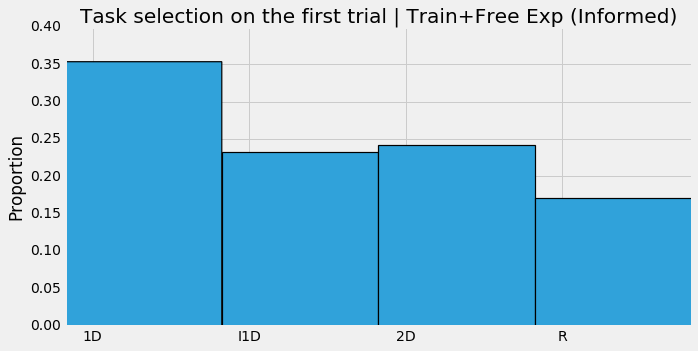

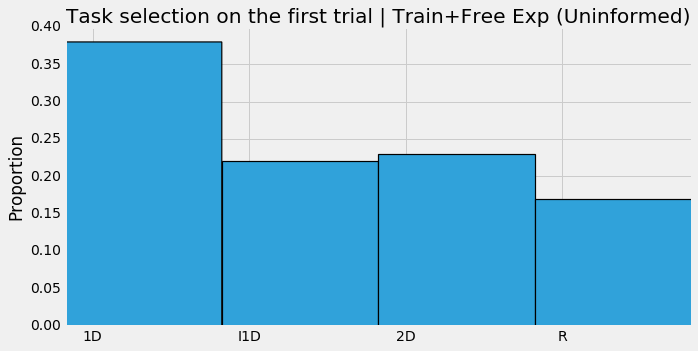

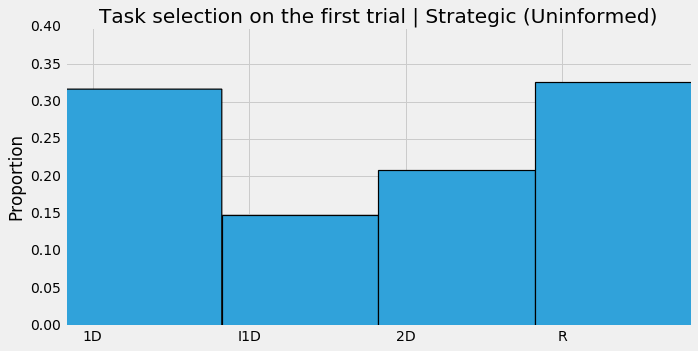

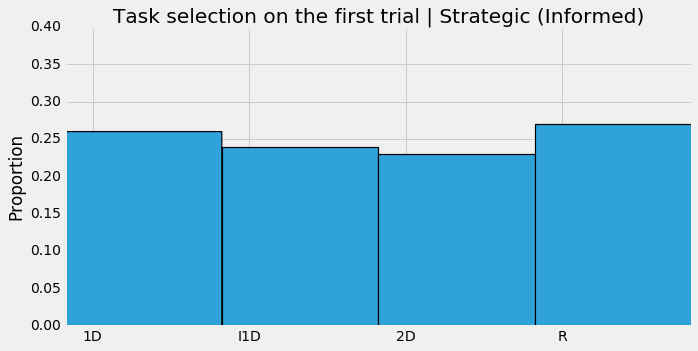

In [17]:

#A4. Performance during training: calculate %correct during the 15 training trials, bin the percentages, 
#and plot the % of ppl who selected a task with the PC in each bin. 

def checkFirstOption(arr, usersArr):
    firstSelec = []
    incomplete = []
    for u in range(usersArr):
        # If it's necessary to check those that didn't explore all tasks (e.g. free exploration only)
        firstSelec.append(arr[u][0,1])
            
    # Return also a list of people who didn't explore all tasks
    return np.asarray(firstSelec)
    
def plotFirstOption(arr, usersArr, label):
    
    firstSelec= checkFirstOption(arr, usersArr)
    ind = np.arange(tasks)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(firstSelec, bins=np.arange(5), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial | ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))
    ax.set_ylim([0,0.4])

#plotFirstOption(splitCsvFTE, usersFT, 'Train+Free Exp (All)')

plotFirstOption(splitCsvFTI, usersFTI, 'Train+Free Exp (Informed)')
plotFirstOption(splitCsvFTU, usersFTU, 'Train+Free Exp (Uninformed)')
#plotFirstOption(splitCsvF, usersF, 'Free Exp', checkIncomplete=True)
plotFirstOption(splitCsvSU, usersSU, 'Strategic (Uninformed)')
plotFirstOption(splitCsvSI, usersSI, 'Strategic (Informed)')


<a id='A3'></a>
## A3 - Order of presentation during training

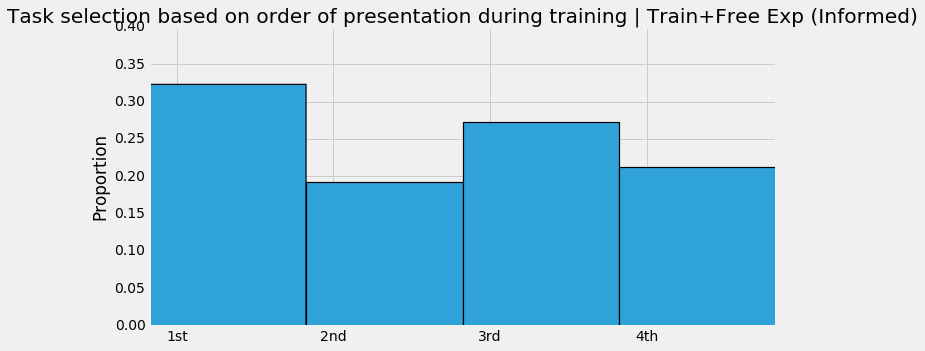

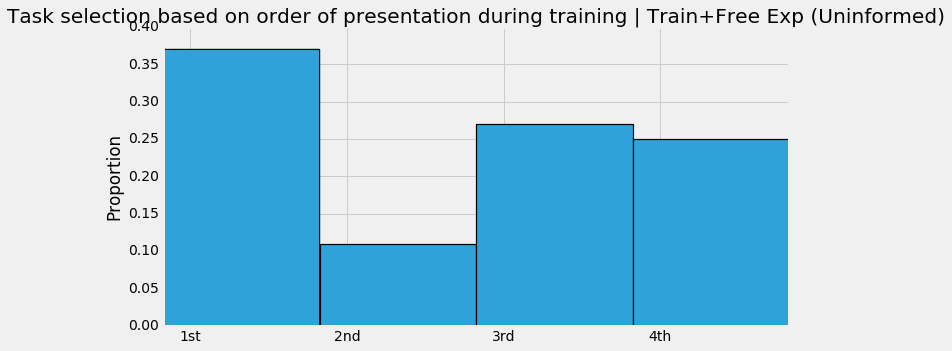

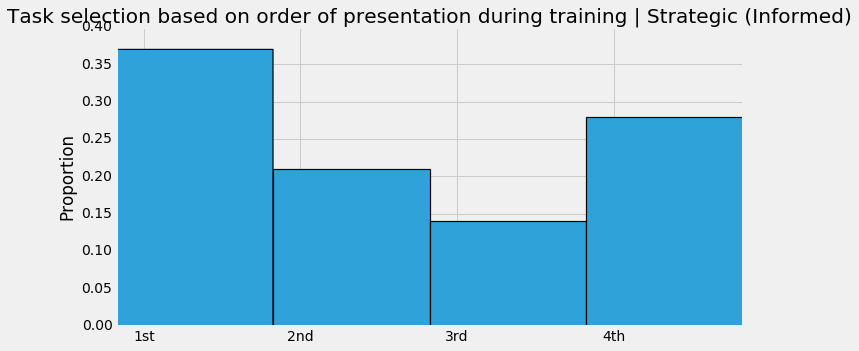

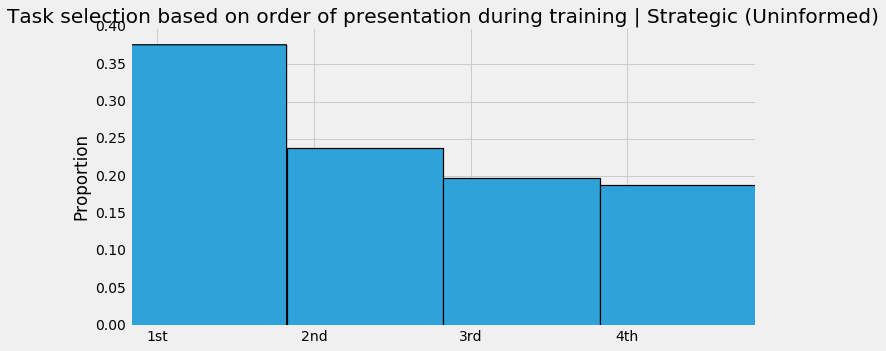

In [18]:
#A3. Order of presentation during training: % ppl who selected the first task they saw during training, 
#the 2nd task, the 3rd, and the 4th. We may see a uniform distributions, or peaks at 1 and 4. 

#ids, informed, phases, categories, correct
# Split by informed or uninformed
a3FTI = csvIntFT[csvIntFT[:,1] == 0,:]
a3FTU = csvIntFT[csvIntFT[:,1] == 1,:]
# Split by user
splita3FTI = [a3FTI[a3FTI[:,0]==i] for i in np.unique(a3FTI[:,0])]
splita3FTU = [a3FTU[a3FTU[:,0]==i] for i in np.unique(a3FTU[:,0])]

a3SI = csvIntS[csvIntS[:,1] == 0,:]
a3SU = csvIntS[csvIntS[:,1] == 1,:]
# Split by user
splita3SI = [a3SI[a3SI[:,0]==i] for i in np.unique(a3SI[:,0])]
splita3SU = [a3SU[a3SU[:,0]==i] for i in np.unique(a3SU[:,0])]

def getFirstSelecOrder(arr, usersArr, strategic=False):
    if strategic:
        trVal = 2
    else:
        trVal = 1
    orderSelec = []
    for u in range(usersArr):
        tmp = arr[u]
        # Get only training part
        # for strategic learning this should be 2
        tmpPhase = tmp[tmp[:,2] == trVal,:]
        # Pass task column and get order indices then get order
        orderIndex = np.unique(tmpPhase[:,3], return_index=True)[1]
        orderTaskUser = [tmpPhase[ind, 3] for ind in sorted(orderIndex)]
        # Get only exploration part
        tmpPhase = tmp[tmp[:,2] == 0,:]
        firstSelec = tmpPhase[0,3]
        # Match that first selection to the order in which it showed up during training
        orderTrain = np.where(orderTaskUser == firstSelec)[0][0]
        #print(orderTaskUser, firstSelec, orderTrain)
        orderSelec.append(orderTrain)
    return orderSelec

def plotFirstSelecOrder(arr, usersArr, label, strategic=False):
    orderSelec = getFirstSelecOrder(arr, usersArr, strategic)
    #print(np.shape(orderSelec), orderSelec)
    
    ind = np.arange(tasks)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(orderSelec, bins=np.arange(5), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection based on order of presentation during training | ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1st', '2nd', '3rd', '4th'))
    ax.set_ylim([0,0.4])

plotFirstSelecOrder(splita3FTI, usersFTI, 'Train+Free Exp (Informed)')
plotFirstSelecOrder(splita3FTU, usersFTU, 'Train+Free Exp (Uninformed)')
plotFirstSelecOrder(splita3SI, usersSI, 'Strategic (Informed)',strategic=True)
plotFirstSelecOrder(splita3SU, usersSU, 'Strategic (Uninformed)',strategic=True)

<a id='A9'></a>
## A9 - Performance during training wrt PC

[ 0.  1.]


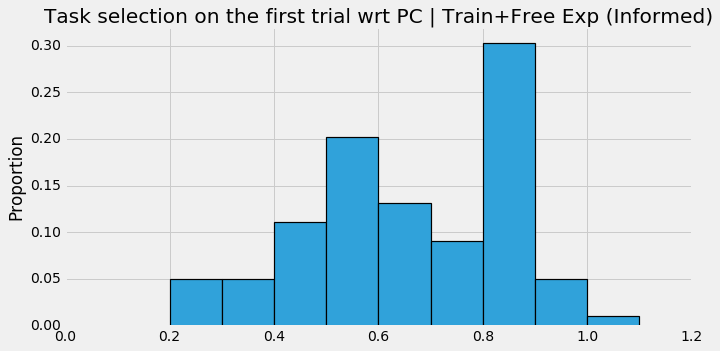

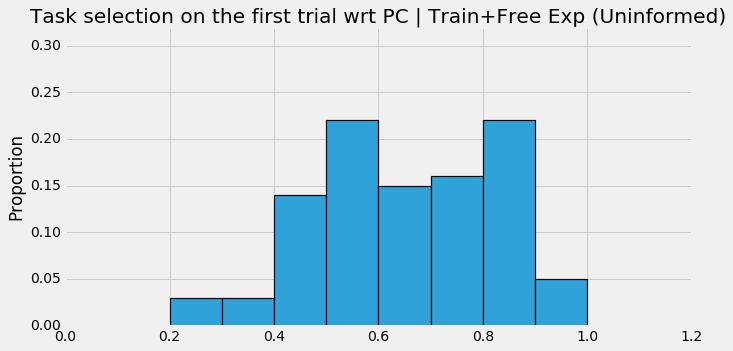

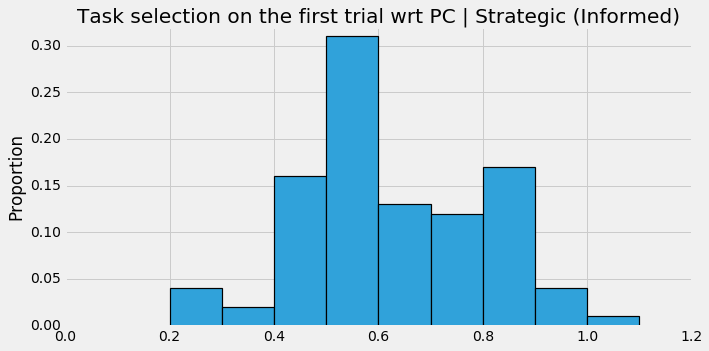

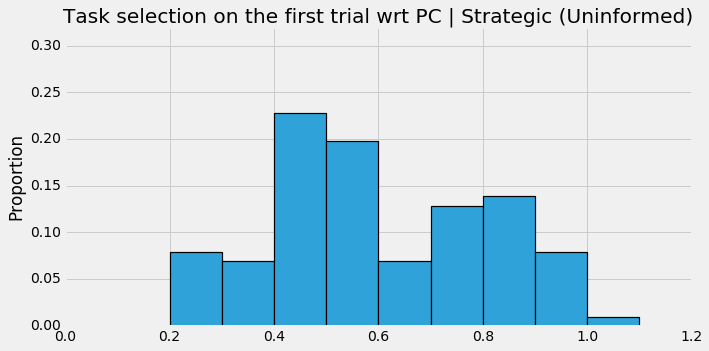

In [19]:
#A4. Performance during training: calculate %correct during the 15 training trials, bin the percentages, 
#and plot the % of ppl who selected a task with the PC in each bin. 

#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(6:11)
# # correct (5), % clection according to the order of presentation during trainingorrect (6)

# Split those informed and those uninformed. (col 1)
ift = freeTTr[freeTTr[:,1]==0,:]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

print np.unique(straTr[:,1])
# Get task first selections
selFTI = checkFirstOption(splitCsvFTI, usersFTI)
selFTU = checkFirstOption(splitCsvFTU, usersFTU)
selSI = checkFirstOption(splitCsvSI, usersSI)
selSU = checkFirstOption(splitCsvSU, usersSU)

# Get training pc of the first task selected
def checkPerformance(arr, firstSelec):
    #print firstSelec[0].tolist()
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    #print "shae",np.shape(splitArr)
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    pcTrain = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only % correct of the row that corresponds to first selection
        #tmprow = sub[sub[:,2] == firstSelec[0].tolist()[u],6]
        tmprow = sub[sub[:,2] == firstSelec[u],6]
        pcTrain.append(tmprow[0])
    return pcTrain
    
def plotPerformance(arr, firstSelec, label):
    
    performance = checkPerformance(arr, firstSelec)
    
    # Create bins (0 - 1 in 0.1 steps)
    binsPC = np.linspace(0,1.1,12)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    plt.hist(performance, bins=binsPC, weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt PC | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_ylim([0,0.32])

        
# Verification

plotPerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotPerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotPerformance(istr,selSI, 'Strategic (Informed)')
plotPerformance(ustr,selSU, 'Strategic (Uninformed)')

Goal: we want to answer the following questions quantitatively. 
How is the first selection influenced by
* training performance - done
* estimate of learnability after training - done
* task instructions (group type)
* the knowledge that one of the tasks is unlearnable (informed vs uninformed comparison)

<a id='A10'></a>
## A10 Relative Performance during training

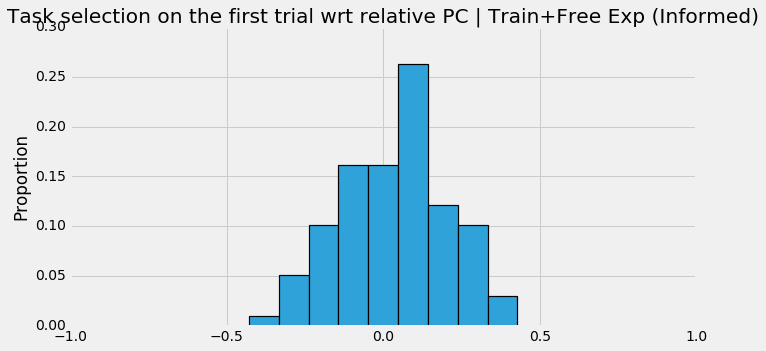

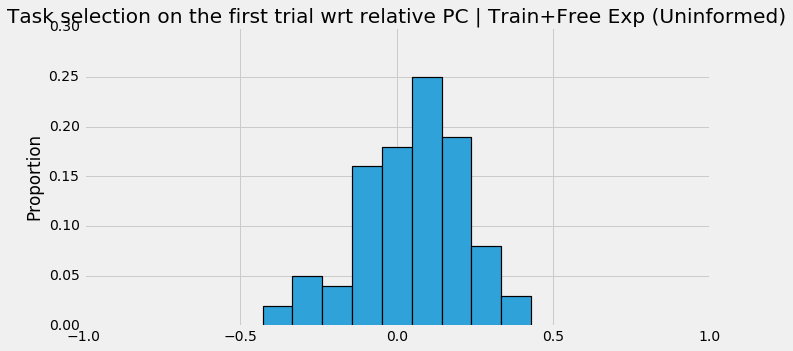

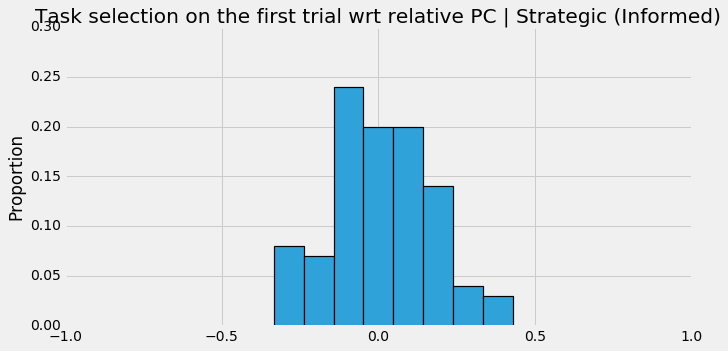

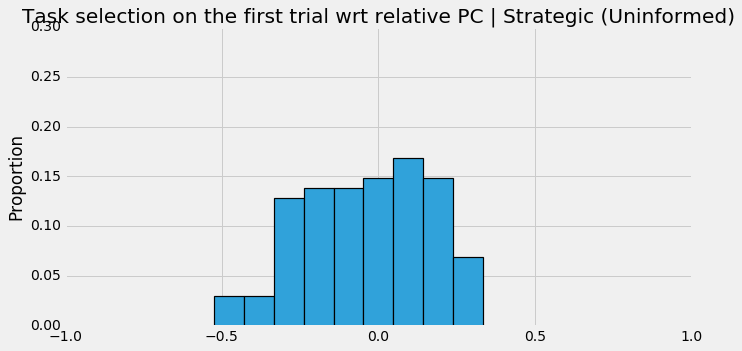

In [20]:
#A6. Relative performance during training: for each participant, take the value representing the PC for 
#each task during training, and normalize it by the mean PC across all 4 tasks. Plot the % of ppl who 
#selected a task as a function of its normalized PC.
# Split those informed and those uninformed. (col 1)
ift = freeTTr[freeTTr[:,1]==0,:]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

# Get relative training pc of the first task selected
def checkRelativePerformance(arr, firstSelec):
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    # Normalized
    pcTrain = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only % correct of the row that corresponds to first selection
        tmprow = sub[sub[:,2] == firstSelec[u],6]
        # get % correct of all tasks and calculate mean
        pcNorm = np.mean(sub[:,6])
        # Append normalized pc
        pcTrain.append(tmprow[0]-pcNorm)
        
    return pcTrain

def plotRelativePerformance(arr, firstSelec, label):
    
    performance = checkRelativePerformance(arr, firstSelec)
    # Create bins (0 - 1 in 0.1 steps)
    binsPC = np.linspace(-1,1,22)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    plt.hist(performance, bins=binsPC, weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt relative PC | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_ylim([0,0.3])
    
plotRelativePerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotRelativePerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotRelativePerformance(istr,selSI, 'Strategic (Informed)')
plotRelativePerformance(ustr,selSU, 'Strategic (Uninformed)')

<a id='A11'></a>
## A11 - Learnability after training distribution (by groups)

0.292929292929
0.33
0.39
0.445544554455


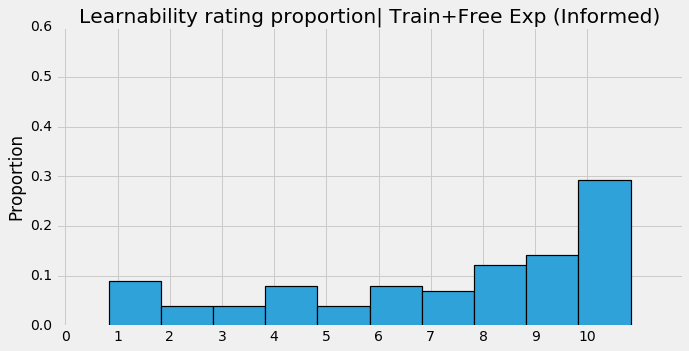

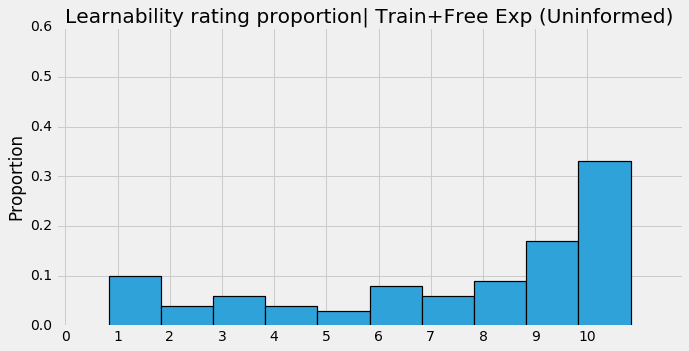

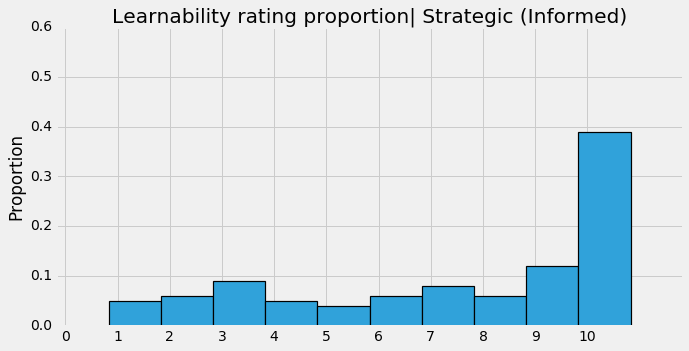

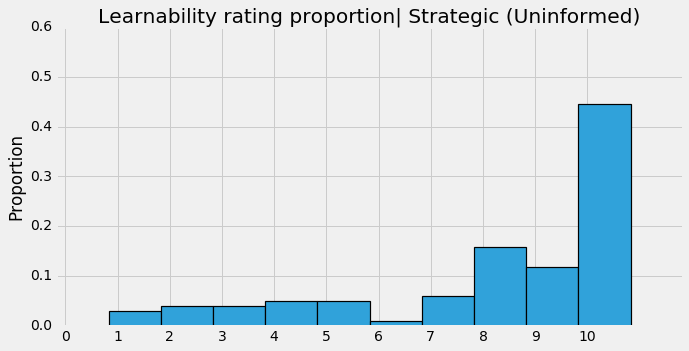

In [21]:

#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(6:11)
# # correct (5), % clection according to the order of presentation during trainingorrect (6)

# Split those informed and those uninformed. (col 1)
ift = freeTTr[freeTTr[:,1]==0,:]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

#print np.unique(straTr[:,1])
# Get task first selections
selFTI = checkFirstOption(splitCsvFTI, usersFTI)
selFTU = checkFirstOption(splitCsvFTU, usersFTU)
selSI = checkFirstOption(splitCsvSI, usersSI)
selSU = checkFirstOption(splitCsvSU, usersSU)

# Get training pc of the first task selected
def learnability(arr, firstSelec):
    #print firstSelec[0].tolist()
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    lrating = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only learnability rating of the row that corresponds to first selection
        #tmprow = sub[sub[:,2] == firstSelec[0].tolist()[u],6]
        rating = sub[sub[:,2] == firstSelec[u],12] 
        lrating.append(rating[0])
    return np.array(lrating)
    
def plotPerformance(arr, firstSelec, label):
    
    performance = learnability(arr, firstSelec)
    # Create bins (0 - 1 in 0.1 steps)
    #p1=performance[performance[:] == 10]
    p1 = len(performance[performance == 10])
    
    print p1/len(performance)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    ind = np.arange(11)
    width = 0.35
    plt.hist(performance, bins=np.arange(12), weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(firstSelec, bins=np.arange(10), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Learnability rating proportion| ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11'))
    ax.set_ylim([0,0.6])

        
# Verification

plotPerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotPerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotPerformance(istr,selSI, 'Strategic (Informed)')
plotPerformance(ustr,selSU, 'Strategic (Uninformed)')



<a id='A12'></a>
## A12 - Relative Learnability after training distribution (by groups)

0.0
0.0
0.0
0.0


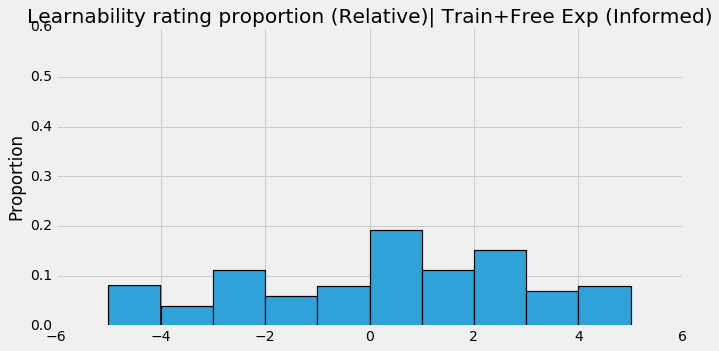

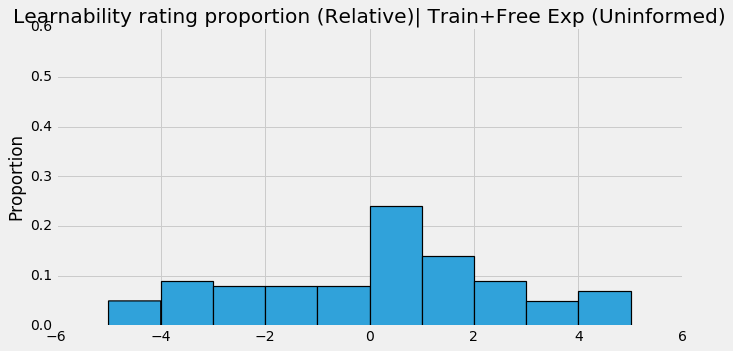

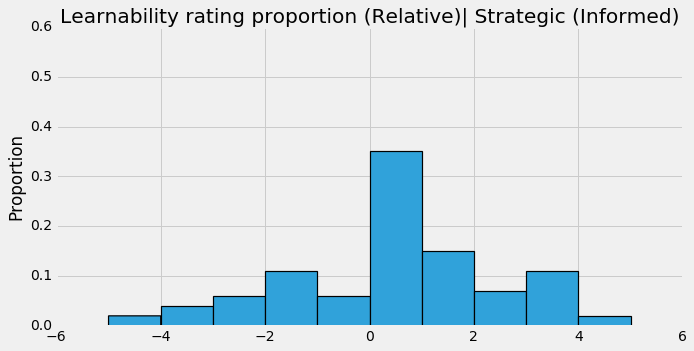

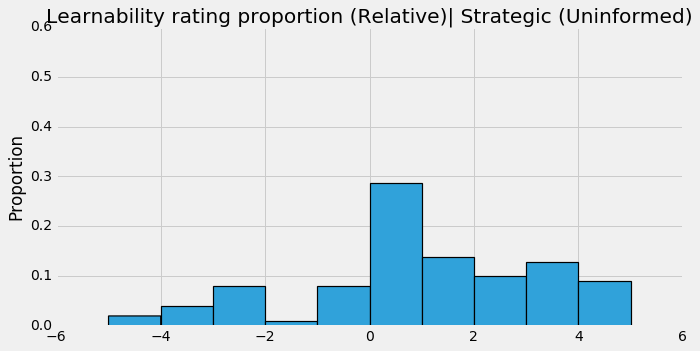

In [22]:
#A4. Performance during training: calculate %correct during the 15 training trials, bin the percentages, 
#and plot the % of ppl who selected a task with the PC in each bin. 

#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(6:11)
# # correct (5), % clection according to the order of presentation during trainingorrect (6)

# Split those informed and those uninformed. (col 1)
ift = freeTTr[freeTTr[:,1]==0,:]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

#print np.unique(straTr[:,1])
# Get task first selections
selFTI = checkFirstOption(splitCsvFTI, usersFTI)
selFTU = checkFirstOption(splitCsvFTU, usersFTU)
selSI = checkFirstOption(splitCsvSI, usersSI)
selSU = checkFirstOption(splitCsvSU, usersSU)

# Get training pc of the first task selected
def learnability(arr, firstSelec):
    #print firstSelec[0].tolist()
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    #print "shae",np.shape(splitArr)
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    lrating = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only % correct of the row that corresponds to first selection
        #tmprow = sub[sub[:,2] == firstSelec[0].tolist()[u],6]
        rating = sub[sub[:,2] == firstSelec[u],12]
        # get learnability rating of all tasks and calculate mean
        pcNorm = np.mean(sub[:,12])
        lrating.append(rating[0]-pcNorm)
    return np.array(lrating),pcNorm
    
def plotPerformance(arr, firstSelec, label):
    
    performance,pcNorm = learnability(arr, firstSelec)
    # Create bins (0 - 1 in 0.1 steps)
    #p1=performance[performance[:] == 10]
    p1 = len(performance[performance == 10])
    
    print p1/len(performance)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    ind = np.arange(-5,6)
    width = 0.35
    plt.hist(performance, bins=np.arange(-5,6), weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(firstSelec, bins=np.arange(10), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Learnability rating proportion (Relative)| ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11'))
    ax.set_ylim([0,0.6])
   

        
# Verification

plotPerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotPerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotPerformance(istr,selSI, 'Strategic (Informed)')
plotPerformance(ustr,selSU, 'Strategic (Uninformed)')


<a id='A13'></a>
## A13 - Learnability after training distribution (by complexity)

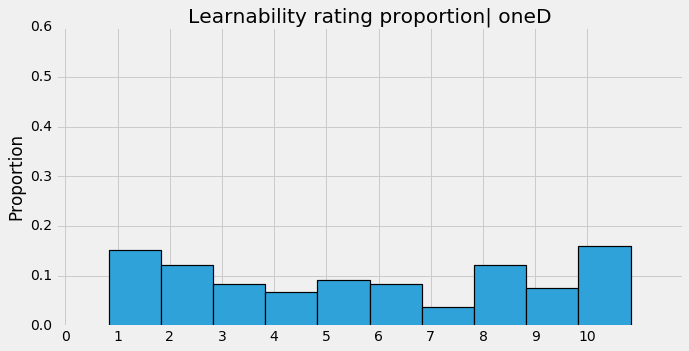

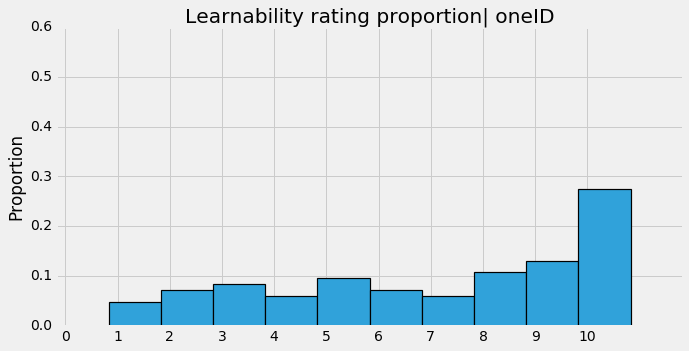

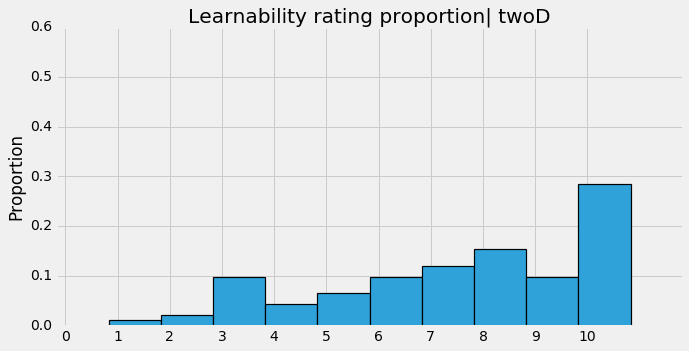

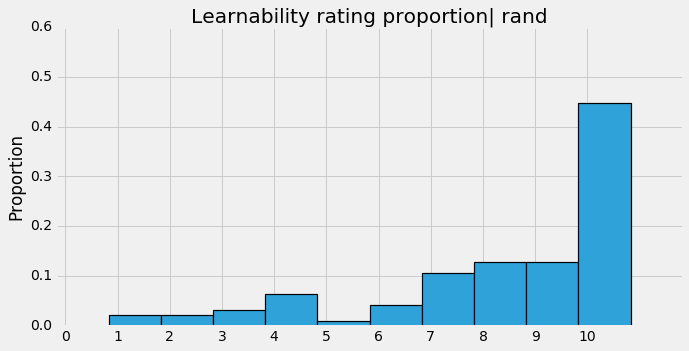

In [23]:



#Combine informed and uninformed to later form record_category
selFT = checkFirstOption(np.concatenate((splitCsvFTI,splitCsvFTU),axis=0),usersFTI+usersFTU)
selST = checkFirstOption(np.concatenate((splitCsvSI,splitCsvSU),axis=0), usersSI+usersSU)

#Create records separated by category (1D,1ID,2D,R) instead of informed/uninformed of Training,Strategic
record_category=[]
# Get stack record of the first task selected
def recordByCategory(arr, firstSelec):

    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    temp_record = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get record of first selected 
        #temp_record.append(sub[sub[:,2] == firstSelec[u]][0])
        record_category.append(sub[sub[:,2] == firstSelec[u]][0])
    
def plotLearnability(arr, label):
    
    learn = arr[:,12]
    # Create bins (0 - 1 in 0.1 steps)
    #p1=performance[performance[:] == 10]
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(learn)/len(learn)
    ind = np.arange(11)
    width = 0.35
    plt.hist(learn, bins=np.arange(12), weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(firstSelec, bins=np.arange(10), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Learnability rating proportion| ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11'))
    ax.set_ylim([0,0.6])

        
# Verification

recordByCategory(np.vstack([ift,uft]),selFT)
recordByCategory(np.vstack([istr,ustr]),selST)
record_category=np.asarray(record_category)


oneD = record_category[record_category[:,2]==0,:]
oneID = np.array(record_category[record_category[:,2]==1,:])
twoD = np.array(record_category[record_category[:,2]==2,:])
rand = np.array(record_category[record_category[:,2]==3,:])


plotLearnability(oneD,'oneD')
plotLearnability(oneID, 'oneID')
plotLearnability(twoD, 'twoD')
plotLearnability(rand, 'rand')


#### Which effects are statistically significant?
- Use all 4 groups that received training (leave out the free exploration without training for now) 
- Look at two of the variables Alvaro plotted: task ID (A1) and relative %correct (A9,A10), and your new relative learnability variable (A11,A12)

Analysis 1: use a a chi-square test of proportions to compare the distributions
For each variable (A1, A9 and relative learnability), compare the distributions for each pair of groups (6 possible pairwise comparisons)
you should have 3*6 = 12 results from these paired chi-square tests
For each variable, show a comparison matrix with the p value in each entry (highlight the significant ones)

Analysis 2: simply compare the distribution means (medians) using a Wilcoxon test (e.g., is the training performance in one group’s first selections different from the performance of another group?)
you should have 3 variables*6 pairwise comparisons = 12 results 
For each variable, show a comparison matrix with the p value in each entry (highlight the significant ones)

#### How do people estimate learnability based on performance?

Analysis 1: group data
* From the training phase (for the 4 groups that had this phase), gather the %correct across all the training trials; this gives you 4 points for each
participant (one per task).
* plot the estimate of future learning as a function of the %correct; each point is one participant for one task (4 points per participant)
* Make a separate plot for each group (free inf, free uninf, strategic inf, strategic uninf),
* In each plot, color the 4 tasks in different colors (this will show approximately how they separate by %correct and by estimates of learnability)
* Fit each plot with a linear trend – see if the slope is significant; if it looks more quadratic try that fit as well
* Plot the 4 plots side by side using the same x and y axes for easy comparison
* Goal: get an idea on whether (1) learnability is inversely correlated with performance, (2) the random task is an exception (low performance and low learnability)

Analysis 2: individual patterns
* Do different people have different strategies for assigning learnability? For instance, some people may say that everything is learnable
* regardless of performance, some may say everything is not learnable regardless of performance, some people may have a linear relation that may be positive or negative, others may have a threshold-like function that is ascending or descending, others may be just random
* Let’s say we plot, for each person, performance vs learnability, draw a line connecting the 4 points in the plot, and then cluster these patterns.
* Would the participants fall into distinct strategies??
* I would try this for all participants together and then see if the strategy groups are evenly distributed across any clusters you may find.

<a id='A14'></a>
## A14 - Group Analysis (Linear Fit)

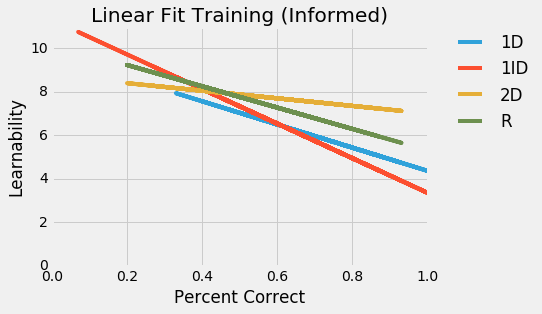

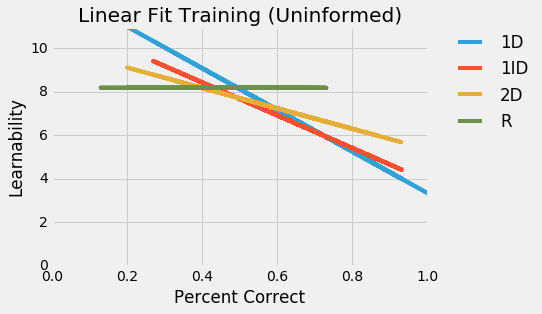

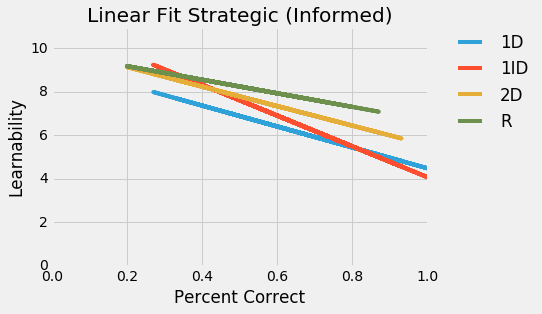

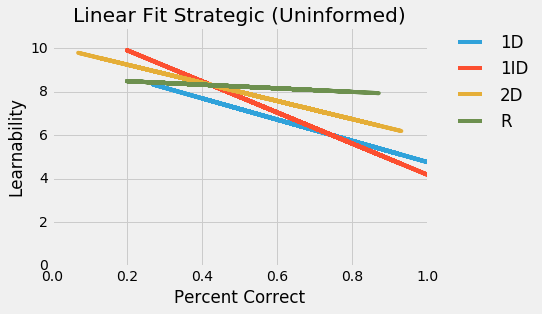

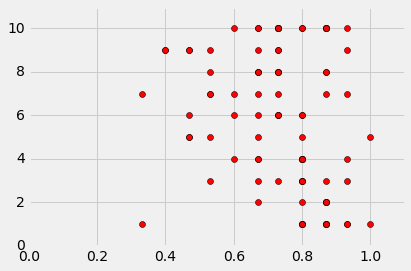

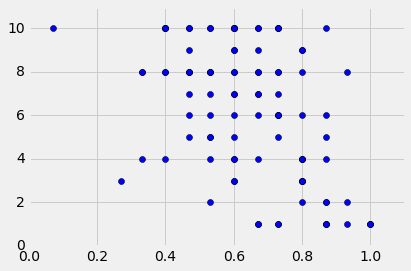

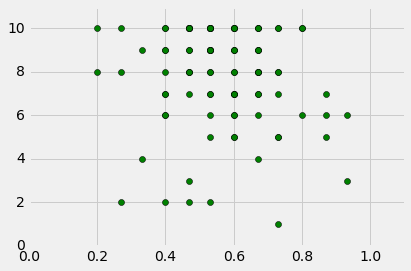

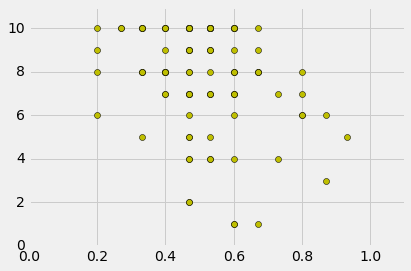

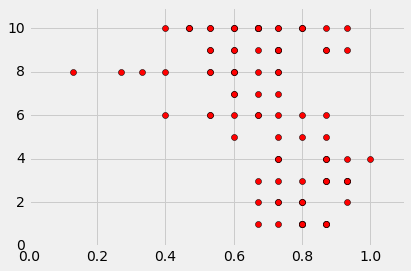

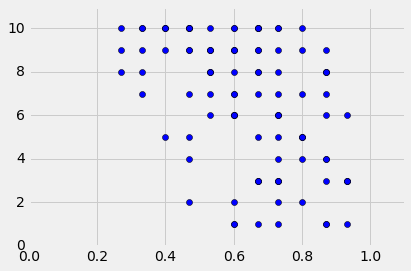

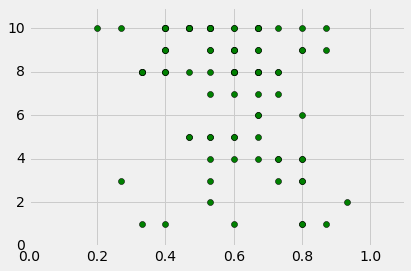

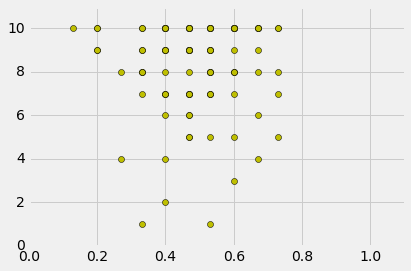

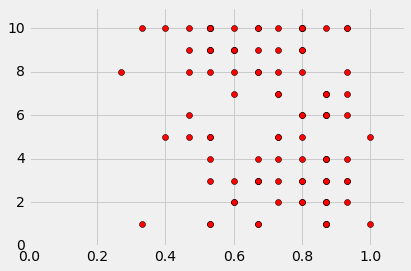

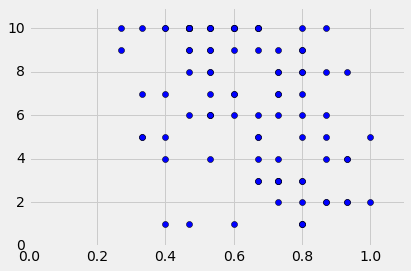

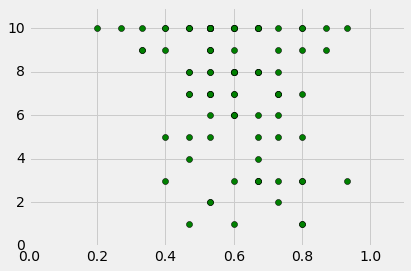

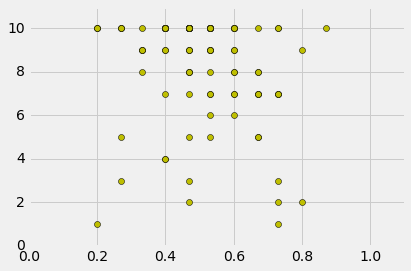

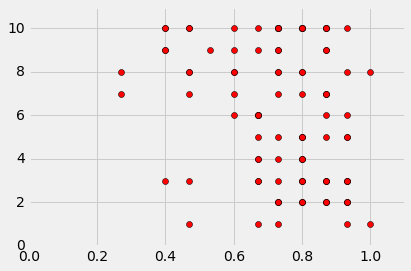

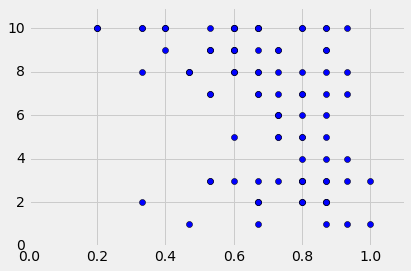

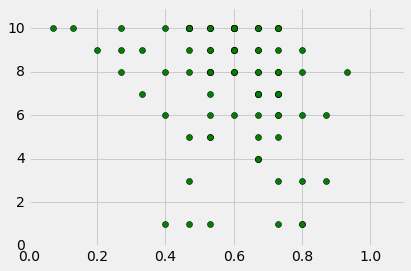

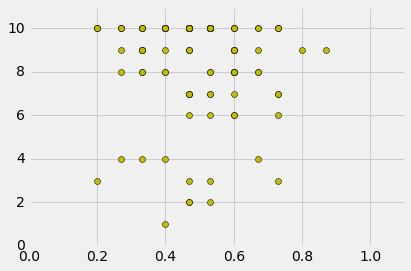

In [24]:
ift = freeTTr[freeTTr[:,1]==0]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

plt.figure(0)

# Fill data (1)
xi = ift[ift[:,2]==0][:,6]
y  = ift[ift[:,2]==0][:,12]

# Generated linear fit(1)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'ro', xi, line)

line1 = plt.plot(xi,line,label="1D")
pylab.title('Linear Fit Training (Informed)')
ax = plt.gca()

# Fill data (2)
xi = ift[ift[:,2]==1][:,6]
y  = ift[ift[:,2]==1][:,12]

# Generated linear fit(2)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

line2 = plt.plot(xi,line,label="1ID")

#plt.plot(xi,y,'bo', xi, line)
ax = plt.gca()

# Fill data (3)
xi = ift[ift[:,2]==2][:,6]
y  = ift[ift[:,2]==2][:,12]

# Generated linear fit (3)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'go', xi, line)
line3 = plt.plot(xi,line,label="2D")
ax = plt.gca()


# Fill data (4)
xi = ift[ift[:,2]==3][:,6]
y  = ift[ift[:,2]==3][:,12]

# Generated linear fit (4)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'yo', xi, line)
line4 = plt.plot(xi,line,label="R")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax = plt.gca()

fig = plt.gcf()
plt.xlim(0.0,1.0)
plt.xlabel('Percent Correct')
plt.ylabel('Learnability')
plt.ylim(0,11)
plt.show()


#Training Uninformed
#-------------------------------------
plt.figure(20)

# Fill data (1)
xi = uft[uft[:,2]==0][:,6]
y  = uft[uft[:,2]==0][:,12]

# Generated linear fit(1)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'ro', xi, line)

line1 = plt.plot(xi,line,label="1D")
pylab.title('Linear Fit Training (Uninformed)')
ax = plt.gca()

# Fill data (2)
xi = uft[uft[:,2]==1][:,6]
y  = uft[uft[:,2]==1][:,12]

# Generated linear fit(2)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

line2 = plt.plot(xi,line,label="1ID")

#plt.plot(xi,y,'bo', xi, line)
ax = plt.gca()

# Fill data (3)
xi = uft[uft[:,2]==2][:,6]
y  = uft[uft[:,2]==2][:,12]

# Generated linear fit (3)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'go', xi, line)
line3 = plt.plot(xi,line,label="2D")
ax = plt.gca()


# Fill data (4)
xi = uft[uft[:,2]==3][:,6]
y  = uft[uft[:,2]==3][:,12]

# Generated linear fit (4)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'yo', xi, line)
line4 = plt.plot(xi,line,label="R")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax = plt.gca()

fig = plt.gcf()
plt.xlim(0.0,1.0)
plt.xlabel('Percent Correct')
plt.ylabel('Learnability')
plt.ylim(0,11)
plt.show()

#----------------------------------------------------------------
#Strategic informed
plt.figure(21)

# Fill data (1)
xi = istr[istr[:,2]==0][:,6]
y  = istr[istr[:,2]==0][:,12]

# Generated linear fit(1)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'ro', xi, line)

line1 = plt.plot(xi,line,label="1D")
pylab.title('Linear Fit Strategic (Informed)')
ax = plt.gca()

# Fill data (2)
xi = istr[istr[:,2]==1][:,6]
y  = istr[istr[:,2]==1][:,12]

# Generated linear fit(2)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

line2 = plt.plot(xi,line,label="1ID")

#plt.plot(xi,y,'bo', xi, line)
ax = plt.gca()

# Fill data (3)
xi = istr[istr[:,2]==2][:,6]
y  = istr[istr[:,2]==2][:,12]

# Generated linear fit (3)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'go', xi, line)
line3 = plt.plot(xi,line,label="2D")
ax = plt.gca()


# Fill data (4)
xi = istr[istr[:,2]==3][:,6]
y  = istr[istr[:,2]==3][:,12]

# Generated linear fit (4)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'yo', xi, line)
line4 = plt.plot(xi,line,label="R")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax = plt.gca()

fig = plt.gcf()
plt.xlim(0.0,1.0)
plt.xlabel('Percent Correct')
plt.ylabel('Learnability')
plt.ylim(0,11)
plt.show()

#--------------------------------------------------------------------------
#Strategic uninformed

plt.figure(21)

# Fill data (1)
xi = ustr[ustr[:,2]==0][:,6]
y  = ustr[ustr[:,2]==0][:,12]

# Generated linear fit(1)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'ro', xi, line)

line1 = plt.plot(xi,line,label="1D")
pylab.title('Linear Fit Strategic (Uninformed)')
ax = plt.gca()

# Fill data (2)
xi = ustr[ustr[:,2]==1][:,6]
y  = ustr[ustr[:,2]==1][:,12]

# Generated linear fit(2)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

line2 = plt.plot(xi,line,label="1ID")

#plt.plot(xi,y,'bo', xi, line)
ax = plt.gca()

# Fill data (3)
xi = ustr[ustr[:,2]==2][:,6]
y  = ustr[ustr[:,2]==2][:,12]

# Generated linear fit (3)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'go', xi, line)
line3 = plt.plot(xi,line,label="2D")
ax = plt.gca()


# Fill data (4)
xi = ustr[ustr[:,2]==3][:,6]
y  = ustr[ustr[:,2]==3][:,12]

# Generated linear fit (4)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'yo', xi, line)
line4 = plt.plot(xi,line,label="R")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax = plt.gca()

fig = plt.gcf()
plt.xlim(0.0,1.0)
plt.xlabel('Percent Correct')
plt.ylabel('Learnability')
plt.ylim(0,11)
plt.show()

#----------------------------------------------------------------------------------

plt.figure(1)
plt.plot(ift[ift[:,2]==0][:,6],ift[ift[:,2]==0][:,12],'ro')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(2)
plt.plot(ift[ift[:,2]==1][:,6],ift[ift[:,2]==1][:,12],'bo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(3)
plt.plot(ift[ift[:,2]==2][:,6],ift[ift[:,2]==2][:,12],'go')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(4)
plt.plot(ift[ift[:,2]==3][:,6],ift[ift[:,2]==3][:,12],'yo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(5)
plt.plot(uft[uft[:,2]==0][:,6],uft[uft[:,2]==0][:,12],'ro') 
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(6)
plt.plot(uft[uft[:,2]==1][:,6],uft[uft[:,2]==1][:,12],'bo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(7)
plt.plot(uft[uft[:,2]==2][:,6],uft[uft[:,2]==2][:,12],'go')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(8)
plt.plot(uft[uft[:,2]==3][:,6],uft[uft[:,2]==3][:,12],'yo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(9)
plt.plot(istr[istr[:,2]==0][:,6],istr[istr[:,2]==0][:,12],'ro') 
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(10)
plt.plot(istr[istr[:,2]==1][:,6],istr[istr[:,2]==1][:,12],'bo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(11)
plt.plot(istr[istr[:,2]==2][:,6],istr[istr[:,2]==2][:,12],'go')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(12)
plt.plot(istr[istr[:,2]==3][:,6],istr[istr[:,2]==3][:,12],'yo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(13)
plt.plot(ustr[ustr[:,2]==0][:,6],ustr[ustr[:,2]==0][:,12],'ro') 
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(14)
plt.plot(ustr[ustr[:,2]==1][:,6],ustr[ustr[:,2]==1][:,12],'bo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(15)
plt.plot(ustr[ustr[:,2]==2][:,6],ustr[ustr[:,2]==2][:,12],'go')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.figure(16)
plt.plot(ustr[ustr[:,2]==3][:,6],ustr[ustr[:,2]==3][:,12],'yo')
plt.xlim(0.0,1.1)
plt.ylim(0,11)

plt.show()

## A11 - Individual Analysis

In [72]:
ift = freeTTr[freeTTr[:,1]==0]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]
straTr2=straTr.copy()
j=-1
for i in range(np.shape(straTr)[0]):
    if i%4==0:
        j+=1
    straTr2[i][0]=(np.shape(freeTTr)[0]/4)+j

total = np.concatenate((freeTTr,straTr2),axis=0)
#plt.plot(total[total[:,2]==0][:,6],total[total[:,2]==0][:,12],'ro')
splitTotal = np.asarray([total[total[:,0]==i] for i in np.unique(total[:,0])])
data=[]
flatten_vector=[]
for i in range(np.shape(splitTotal)[0]):
    data.append(splitTotal[i][:,[0,6,12]])
    flatten_vector.append(splitTotal[i][:,[6,12]].flatten())




In [73]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))

# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(flatten_vector,2)
# assign each sample to a cluster
idx,_ = vq(flatten_vector,centroids)


show()

n_digits: 3, 	 n_samples 400, 	 n_features 8
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________


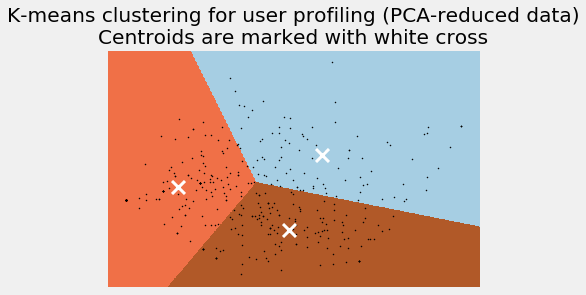

In [80]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)



data = np.asarray(flatten_vector)

n_samples, n_features = data.shape
#n_digits = len(np.unique(digits.target))
n_digits = 3
#labels = digits.target
#print labels
sample_size = 400

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    '''
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    '''
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering for user profiling (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


def plotFirstOption(arr, usersArr, label):
    firstSelec = learnability(arr, usersArr)
    ind = np.arange(10)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(firstSelec, bins=np.arange(10), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Learnability rating proportion| ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    ax.set_ylim([0,0.4])


plotFirstOption(informedFT, usersFTI, 'Train+Free Exp (Informed)')
plotFirstOption(splitCsvFTU, usersFTU, 'Train+Free Exp (Uninformed)')
plotFirstOption(splitCsvSU, usersSU, 'Strategic (Uninformed)')
plotFirstOption(splitCsvSI, usersSI, 'Strategic (Informed)')

For n_clusters = 2 The average silhouette_score is : 0.704978749608


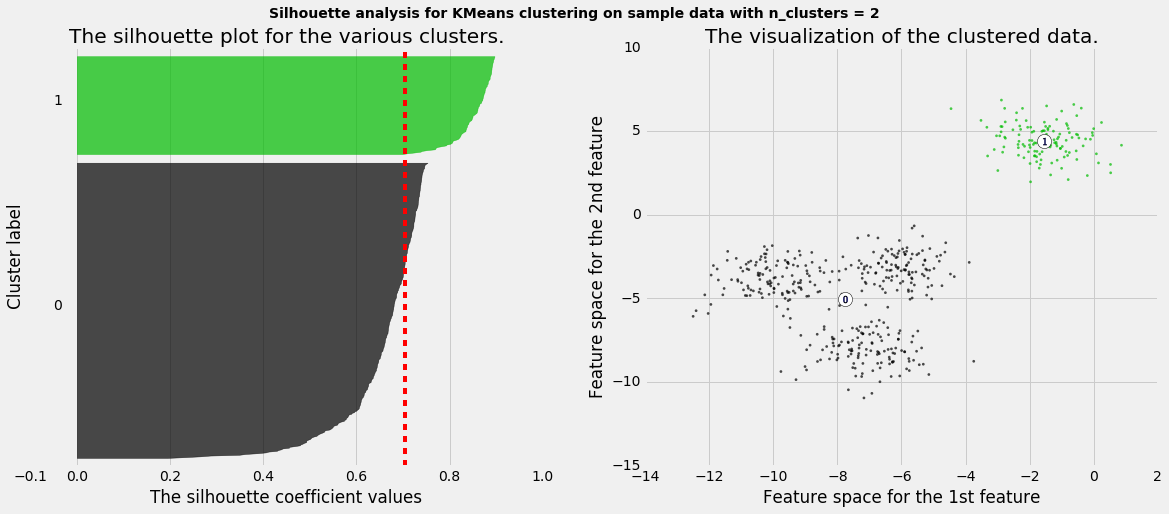

For n_clusters = 3 The average silhouette_score is : 0.588200401213


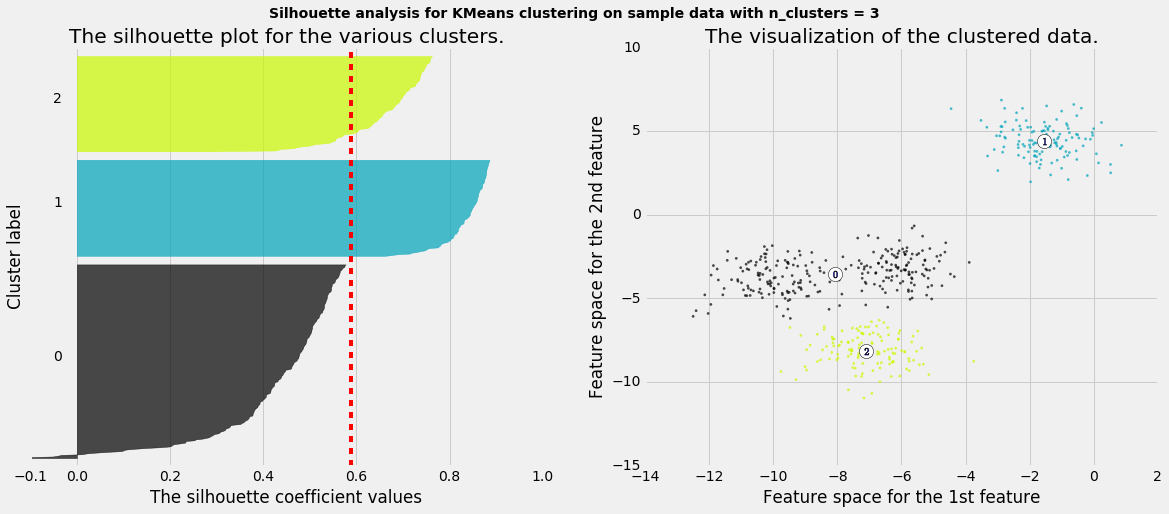

For n_clusters = 4 The average silhouette_score is : 0.650518663273


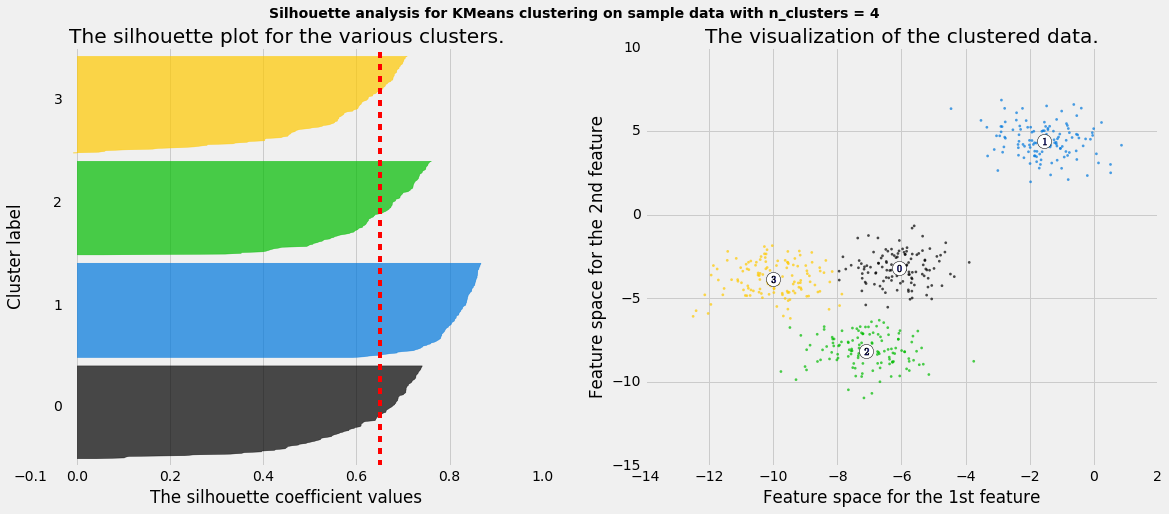

For n_clusters = 5 The average silhouette_score is : 0.563764690262


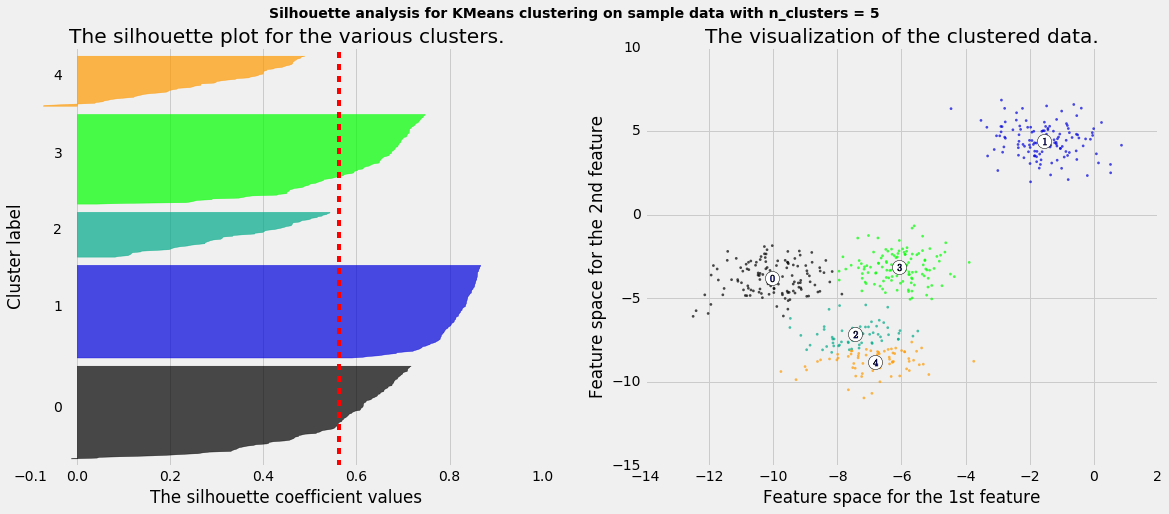

For n_clusters = 6 The average silhouette_score is : 0.450466629437


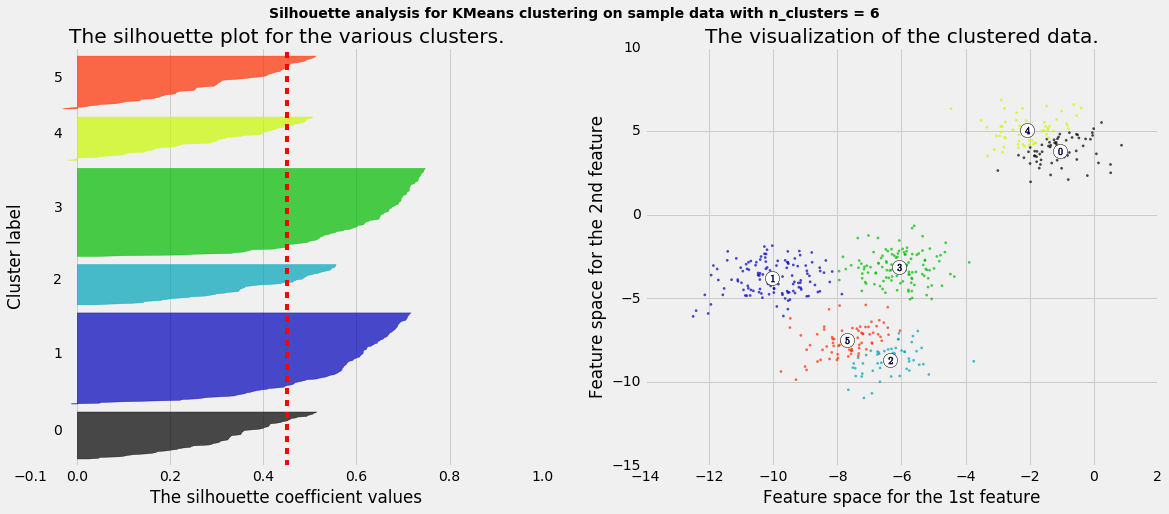

In [75]:

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

 

